# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import random

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of a traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

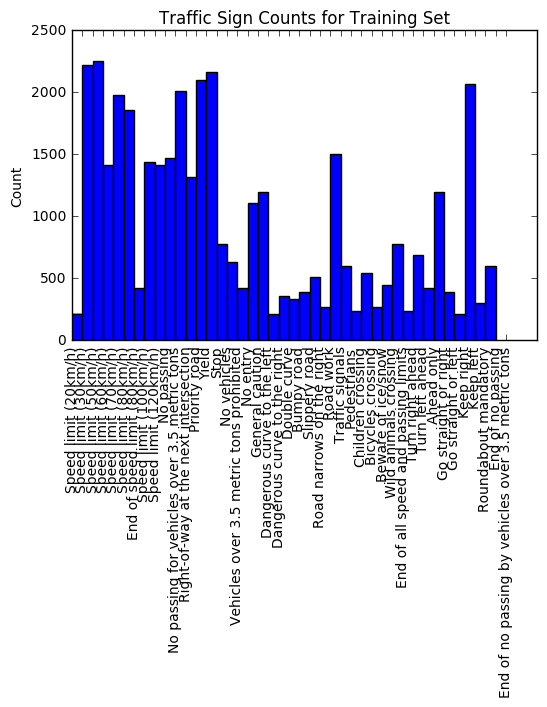

Sample Image:

Road work


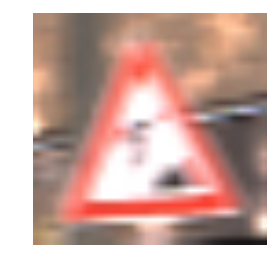

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import pandas as pd

# Visualizations will be shown in the notebook.
%matplotlib inline


def get_name(id):
    names = pd.read_csv("./signnames.csv")
    return names.ix[id].SignName

unique_labels = set(train['labels'])
num_labels = np.arange(len(unique_labels))
label_counts = {}
for label in unique_labels:
    label_counts[label] = 0
for label in train['labels']:
    label_counts[label] += 1

plt.hist(y_train,bins=np.arange(y_train.min(), y_train.max()), width=1)
plt.xticks(range(len(unique_labels)), [get_name(id) for id in unique_labels], rotation=90)
plt.ylabel('Count')
plt.title('Traffic Sign Counts for Training Set')
plt.show()

index = random.randint(0, len(X_train))
img = X_train[index]

print('Sample Image:')
print()
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.axis('off')
print(get_name(y_train[index]))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
from sklearn.utils import shuffle
import cv2
from skimage import exposure
from skimage import img_as_float

# Some difficult images to test on:
#index = 16118
#index = 14819
#index = 11135
#index = 31620

X_train, y_train = shuffle(X_train, y_train)

index = random.randint(0, len(X_train))

before_img = X_train[index]

def preprocess(imgs):
    # convert images to grayscale
    gray_images = []
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray_images.append(img)
        
    imgs = np.array(gray_images, dtype=np.float32)    
    st_dev = np.std(imgs, axis=0)
    
    # normalize images
    normalized_images = []
    for img in imgs:
        # Mean subtraction
        mean_val = np.mean(img)
        img -= mean_val
        
        # Feature standardization
        img /= st_dev
        
        # Contrast stretching
        p1, p99 = np.percentile(img, (1, 99))
        rescale = exposure.rescale_intensity(img, in_range=(p1, p99))
        normalized_images.append(rescale)
        
    imgs = np.array(normalized_images, dtype=np.float32)
    return imgs


X_train = preprocess(X_train)
X_test = preprocess(X_test)

after_img = X_train[index]

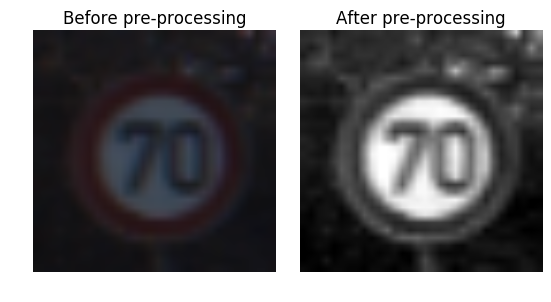

In [5]:
import matplotlib.gridspec as gridspec

g = gridspec.GridSpec(1, 3, wspace=0.1)
fig = plt.figure(figsize=(10,10))
ax1 = plt.Subplot(fig, g[0])
ax2 = plt.Subplot(fig, g[1])
ax3 = plt.Subplot(fig, g[2])

ax1.imshow(before_img)
ax1.set_title('Before pre-processing')

ax2.imshow(after_img, cmap='gray')
ax2.set_title('After pre-processing')

fig.add_subplot(ax1)
plt.axis('off')

fig.add_subplot(ax2)
plt.axis('off')

plt.show()

In [6]:
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

print(X_train.shape)
print(X_test.shape)

(39209, 32, 32, 1)
(12630, 32, 32, 1)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** 
The training set is first shuffled to prevent bias.

The images need to be readable even in variable lighting conditions. Therefore, I converted the images to grayscale. Next, I standardized the data by subracting the mean and dividing the standard deviation. This leaves the data with zero mean and equal variance, which ensures that no one feature of the data will be considered more important than other features and lighting conditions are less important that the actual content of the images.

Lastly, I normalized contrast to improve readablitiy in dark and washed-out images. The solution I settled on for this was contrast stretching. Contrast stretching changes the range of intensity values for pixels in an image. (In this case, images are rescaled to include all intensities that fall within the 1st and 99th percentile). I chose 1 and 99 as the lower and upper limits after testing on a sample of difficult images.

I tried implementing histogram equalization earlier on. However, I found that it was too extreme and it sometimes left me with a washed-out, unnatural looking image. Contrast stretching performed much better on normal and low-contrast images.

I also tried implementing adaptive equalization, but it took too long to process.

I found these sources helpful:

http://people.idsia.ch/~juergen/nn2012traffic.pdf 

https://en.wikipedia.org/wiki/Histogram_equalization

http://scikit-image.org/docs/dev/auto_examples/plot_equalize.html

http://homepages.inf.ed.ac.uk/rbf/HIPR2/stretch.htm

http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing

In [7]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)

print(X_train.shape[0])
print(X_val.shape[0])

31367
7842


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

The test set was already set up, but I used train_test_split from sklearn to separate a validation set from the training set. A benefit of train_test_split is that it uses stratified sampling by default. Sratified sampling is a method of variance reduction. This means the validation set will accurately represent the training set.

In [39]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

epochs = 100
batch_size = 256
keep_probability = 0.7

In [40]:
def LeNet(x):
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    
    # Layer 3: Fully connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.add(tf.matmul(fc0, fc1_W), fc1_b)
    
    # Activation
    fc1 = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.add(tf.matmul(fc1, fc2_W), fc2_b)
    
    # Activation
    fc2 = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(fc2, fc3_W), fc3_b)
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The final architecture is based off of the LeNet model. It has 2 convolutional layers, each followed by relu activation and max pooling, two fully connected layers, each followed by dropout with keep probability of 0.7, and the final fully connected layer.

The first convolutional layer takes an image that is 32x32 pixels. It maps 5x5 pixel sections of the image to feature maps and reduces the size to 28x28. (That's 32 - 5 + 1 = 28. 1 is added from padding.) Then the image is simplified further with max pooling. Max pooling takes 2x2 sections of the convolved output and returns just a single value (the maximum) for each section. This reduces the size to 14x14. (That's 28 / 2 = 14.) This first layer has a depth of 6, meaning it has 6 "slices" or feature maps.

The second convolutional layer is similar. It takes the 6 14x14 "slices" from the first layer as input and reduces the size to 10x10 (14 - 5 + 1 = 10). After max pooling, the shape is 5x5. This layer has a depth of 16.

Before the first fully connected layer, the output tensor is flattened to a vector with a length of 400. (That's 5 x 5 x 16.)

The third layer (fully connected 1) takes the flattened vector as input. This input is multiplied by weights (with shape (400, 120) to create the desired output length) and bias is added. It's output is a vector with a length of 120. The layer is followed by dropout to reduce over-fitting.

The fourth layer is another fully connected layer. It's output is a vector with a length of 84. It is also followed by dropout.

The final layer outputs a vector of logits with a length equal to the number of classes.

In [41]:

x = tf.placeholder(tf.float32, shape=(None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

In [42]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [43]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_train, y_train):
    num_examples = len(X_train)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_train[offset:offset+batch_size], y_train[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_probability})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [46]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    train_acc = []
    val_acc = []
        
    print("Training...")
    print()
    for i in range(epochs):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_probability})
            
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_val, y_val)
        
        train_acc.append(train_accuracy)
        val_acc.append(validation_accuracy)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.546
Validation Accuracy = 0.544

EPOCH 2 ...
Training Accuracy = 0.753
Validation Accuracy = 0.747

EPOCH 3 ...
Training Accuracy = 0.833
Validation Accuracy = 0.825

EPOCH 4 ...
Training Accuracy = 0.869
Validation Accuracy = 0.862

EPOCH 5 ...
Training Accuracy = 0.890
Validation Accuracy = 0.883

EPOCH 6 ...
Training Accuracy = 0.913
Validation Accuracy = 0.905

EPOCH 7 ...
Training Accuracy = 0.924
Validation Accuracy = 0.907

EPOCH 8 ...
Training Accuracy = 0.934
Validation Accuracy = 0.922

EPOCH 9 ...
Training Accuracy = 0.940
Validation Accuracy = 0.934

EPOCH 10 ...
Training Accuracy = 0.948
Validation Accuracy = 0.934

EPOCH 11 ...
Training Accuracy = 0.950
Validation Accuracy = 0.940

EPOCH 12 ...
Training Accuracy = 0.956
Validation Accuracy = 0.941

EPOCH 13 ...
Training Accuracy = 0.961
Validation Accuracy = 0.946

EPOCH 14 ...
Training Accuracy = 0.961
Validation Accuracy = 0.948

EPOCH 15 ...
Training Accuracy = 0.968
Valid

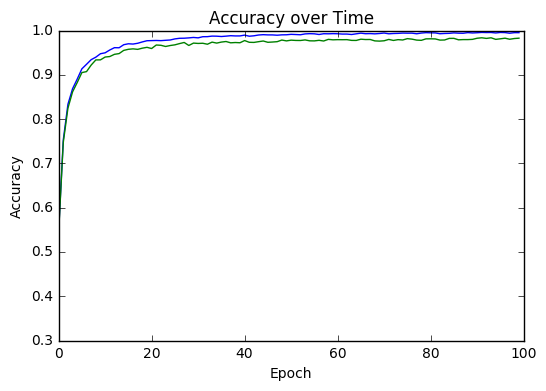

In [48]:
# Visualize Accuracy

plt.plot(train_acc)
plt.plot(val_acc)
plt.xlim(0, 100)
plt.ylim(0.3, 1.0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Time')

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used Adam optimizer with learning rate of .001. I trained the model for 100 epochs with batch size of 256.

The first variable I started changing was the learning rate. Initially, I chose a learning rate of .001. I found that increasing by a magnitude of 10 reduced the accuracy slightly and decreasing by a magnitude of 10 reduced it even more. The higher learning rate caused gradient descent to "over-shoot" the minimum and it actually performed worse over time. Increasing epochs can balance the lower learning rate, but too many epochs will take very long to train. I found that a learning rate of .001 was a good balance.

Then I tried different batch sizes. I tried 64, 128, 256, and 512. The batch size with the best accuracy was 256.

Next I increased the number of epochs until my accuracy stopped improving significantly. I rounded up to 50 epochs.

The last step was adding dropout on two of the hidden layers. I wanted to implement dropout to reduce overfitting. It decreased my training/validation accuracy quite a bit, but I think it improved my test accuracy and it decreased the difference between training and validation accuracy. I ended up with a keep probability of 0.7.

I then added more epochs to see if that would balance the decreased accuracy from dropout. With 100 epochs, I was able to achieve higher accuracy.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started with the LeNet architecture from the LeNet lab. Then I started changing batch size, epochs, and learning rate as a trial and error process. I chose Adam optimizer because it's very computationally efficient and it handles learning rate decay.

I wanted to use a CNN to solve this problem because they have proven to be very accurate at classifying images.

Each layer in the model is followed by an activation funciton. I chose ReLU as the activation function for all of my hidden layers. After doing some research on different activation functions, I learned that one major advantage of ReLU over sigmoid is a reduced likelihood of vanishing gradient, which means faster learning. The gradient of a sigmoid function becomes increasingly small as the absolute value of x increases, but the gradient of a ReLU function is constant.

In [49]:
# Test the model

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.923


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [50]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
captured_imgs_dir = "./Captured_Traffic_Signs/"

def load_captured_imgs(dir_name):
    img = cv2.imread(dir_name, 0)
    return img

def plot_imgs(imgs, names):
    plt.figure(figsize = (20, 20))
    g = gridspec.GridSpec(7, 5, wspace=0.5, hspace=0.5)
    for i in range(34):
        ax = plt.subplot(g[i])
        plt.imshow(imgs[i], cmap='gray')
        plt.axis('off')
        plt.title(names[i])
    plt.show()

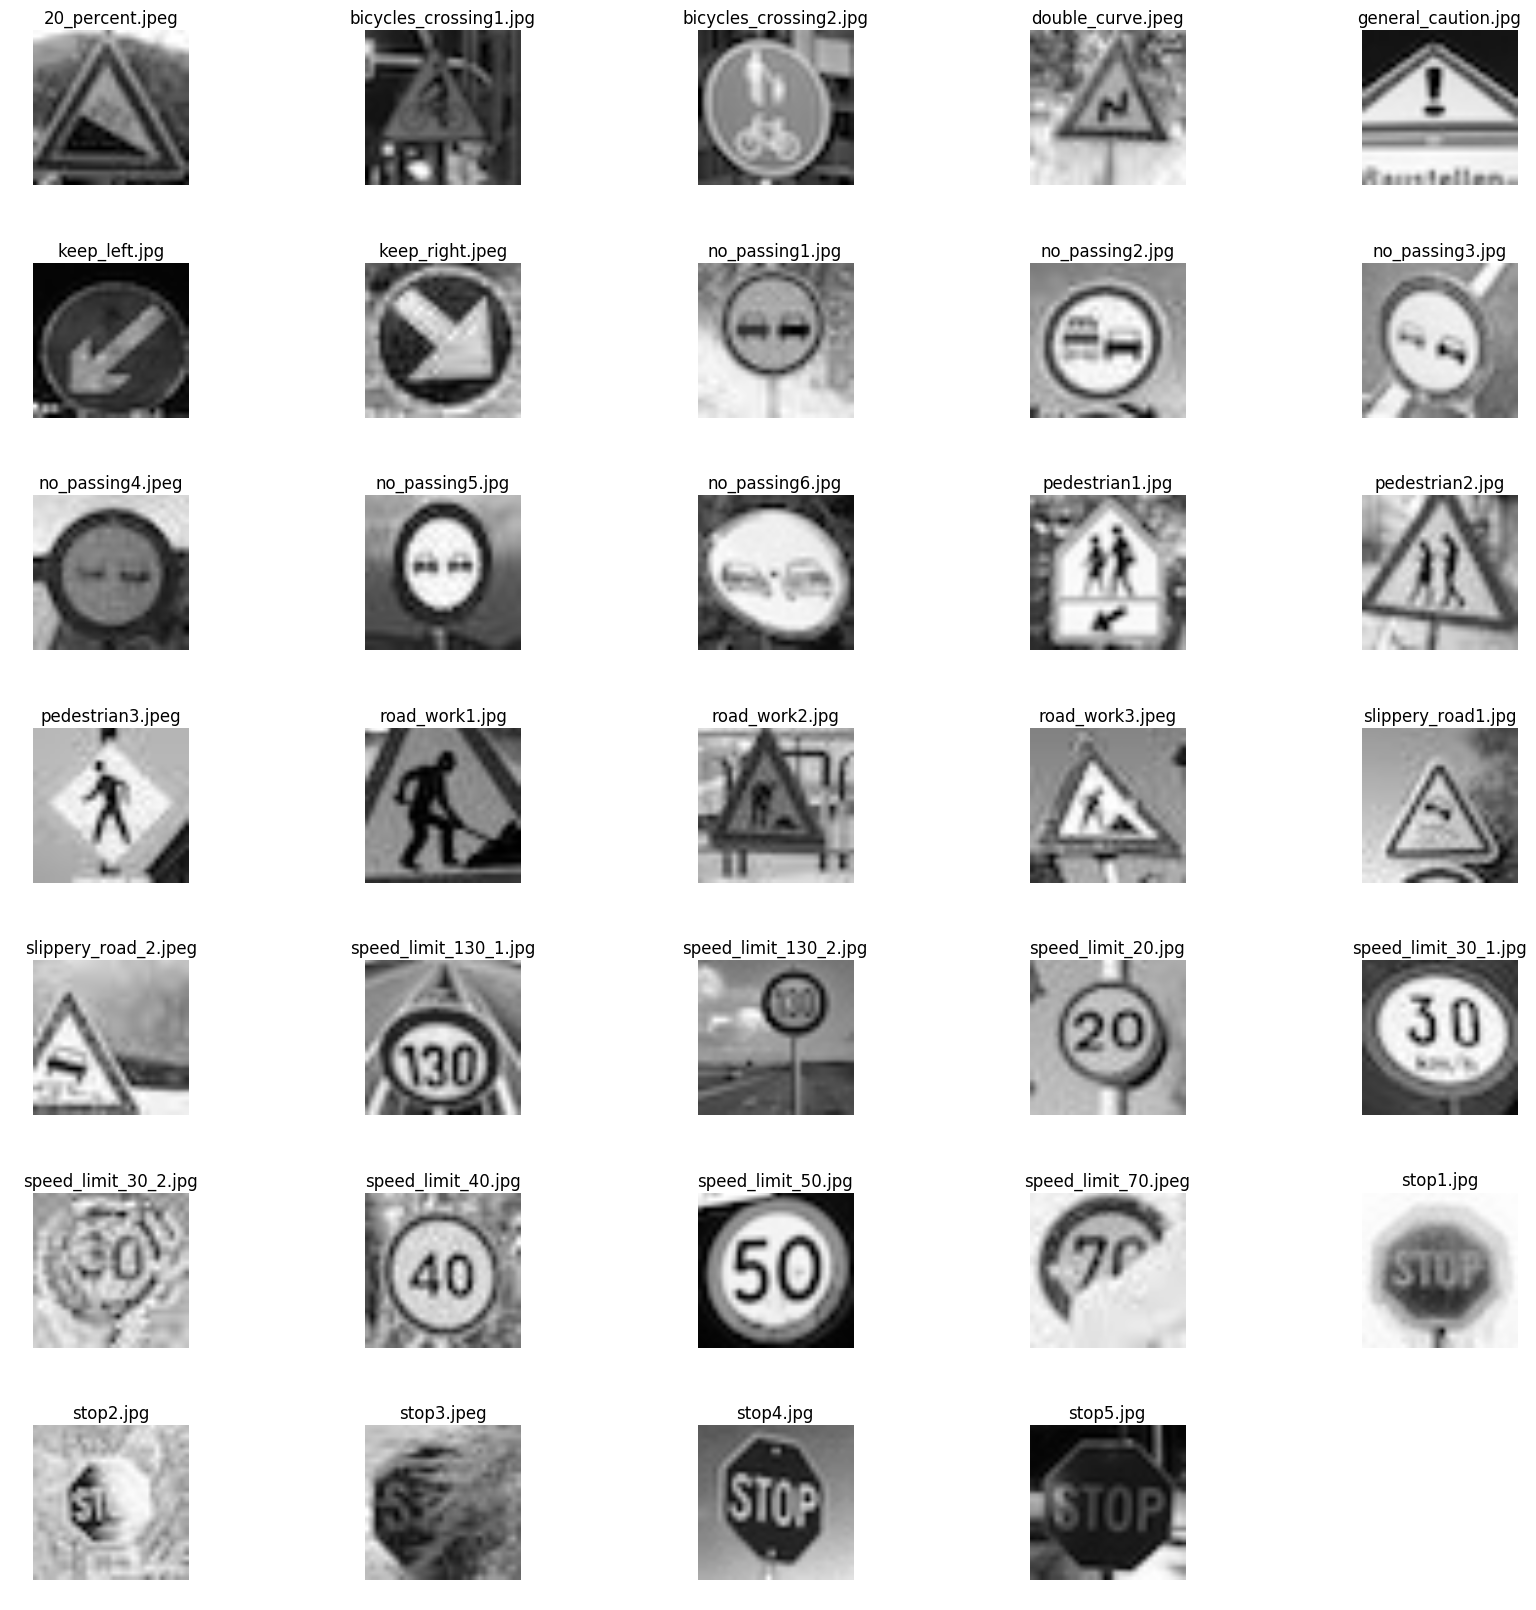

In [51]:
import os

captured_imgs = []
img_names = []
for name in os.listdir(captured_imgs_dir):
    img_names.append(name)
    captured_imgs.append(load_captured_imgs(captured_imgs_dir + name))

captured_imgs = np.array(captured_imgs, dtype=np.float32)
plot_imgs(captured_imgs, img_names)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

There are several images that will be particularly difficult to classify. For example: 
 - Two of the stop sign images and one 70 kph sign are partially obstructed because of snow/ice
 - A "Keep Right" sign uses a different style of arrow than what I've seen in the training set
 - Some images are shifted or cropped, cutting off parts of the sign
 - There new styles of pedestrian signs that are different from the training set
 - One sign has both pedestrians and a bicycle on it
 - There are new speed limit signs (40 kph and 130 kph)
 - There is one new sign warning of a 20% incline
 - One "No Passing" sign is very old and faded
 
I expect the classifier to perform well on signs that it has seen before, but it will fail to classify new signs.

In [55]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
c = tf.nn.softmax(logits)
test_imgs = captured_imgs.reshape(captured_imgs.shape + (1,))
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    classification = sess.run(tf.argmax(c, 1), feed_dict={x: test_imgs, keep_prob: 1})
    print(classification)

[22 12 11 31 12 39 25 17  9 10  9 10 19 11 18 18 10 25 25 23 13 17 25  0 38
 11 16 25 25 13 12  4 14 14]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The accuracy on these new images was 29.4%. It predicted 10/34 images correctly. This is significantly lower than the accuracy on the test set, which was 92.3%. However, it's not a huge surprise. As I explained above, many of the images I imported were very difficult to classify.

As expected, the classifier failed with incomplete images (with part of the sign cropped out) and obstructed images (from trees or snow). If my classifier was better at generalizing, it would be able to recognize the symbol for road work, for example, even though the border of the sign was cut off.

It also perfomed poorly on signs that were a different shape/style from the training set. I didn't expect that to be such a problem. Once again, my classifier failed to generalize enough to recognize the symbol for pedestrians in a different shaped sign.

It failed at predicting the correct speed on all but one speed limit sign. As I mentioned before, some of the speeds were not included in the training set, so I expected it would be unable to classify them. One specific case that I'm very surprised by is a 50 kph sign. The classifier didn't even recognize it as a speed limit sign, even though it is perfectly clear and the same style as the other German signs.

In [56]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
top_5 = tf.nn.top_k(c, 5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run([c, top_5], feed_dict={x: test_imgs, keep_prob: 1})

/Users/cass/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


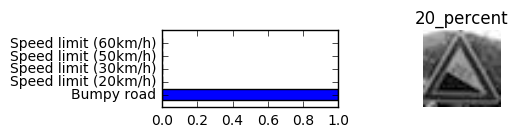

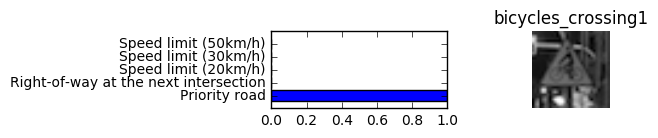

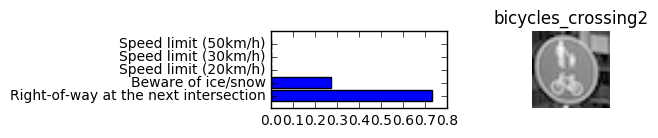

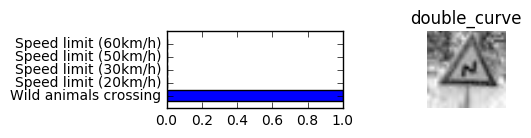

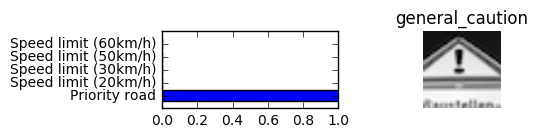

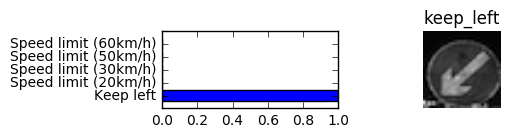

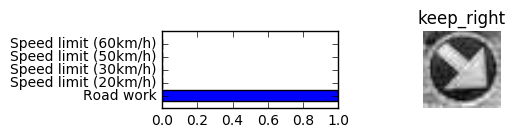

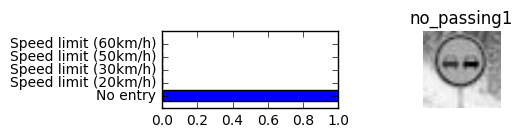

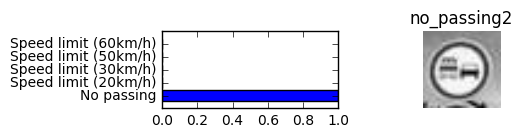

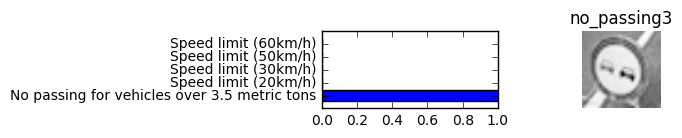

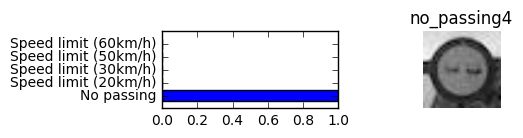

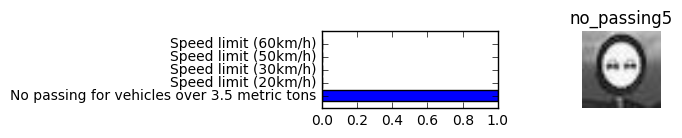

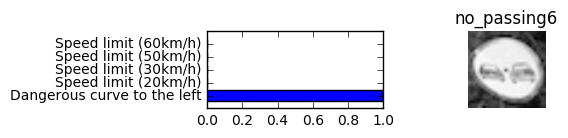

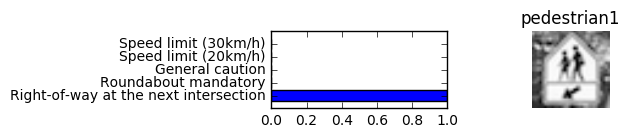

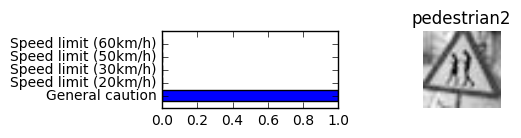

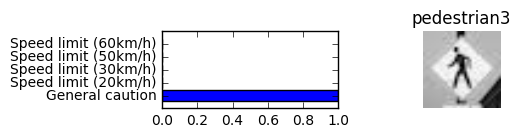

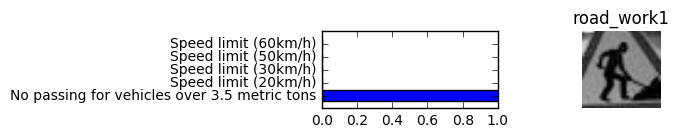

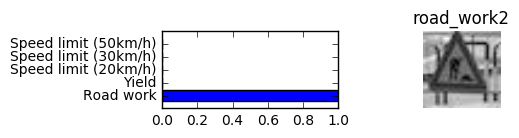

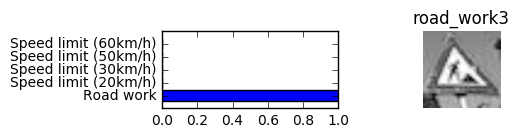

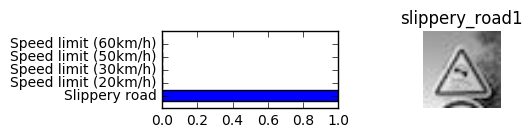

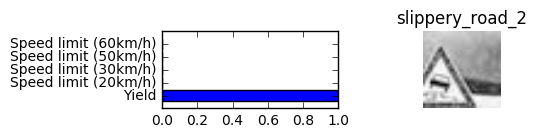

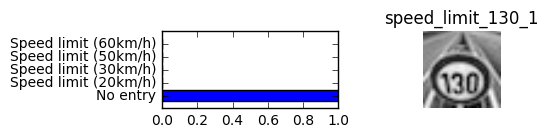

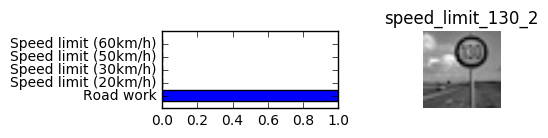

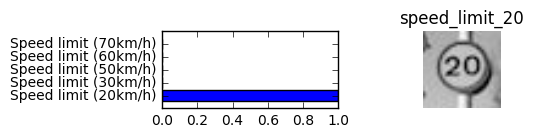

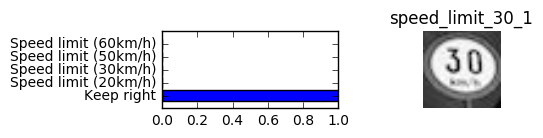

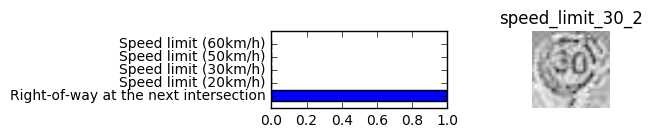

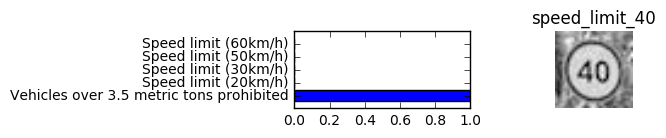

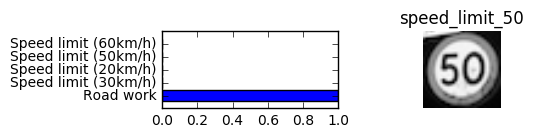

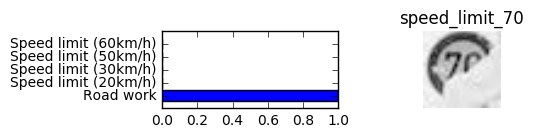

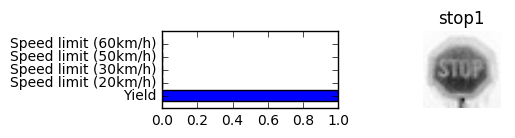

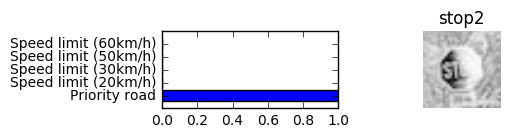

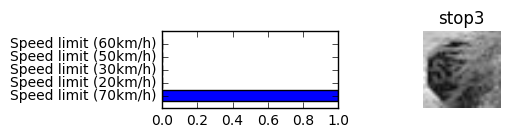

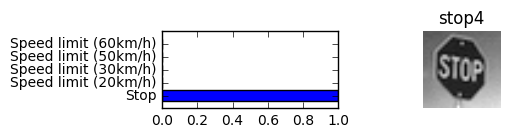

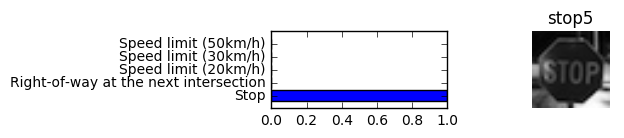

In [57]:
for i, img in enumerate(captured_imgs):
    f = plt.figure(figsize = (5, 1))
    g = gridspec.GridSpec(1, 2)
    ax1 = plt.subplot(g[1])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(img_names[i].split('.')[0])
    ax2 = plt.subplot(g[0])
    plt.barh(np.arange(5), predictions[1][0][i], align='center')
    ids = []
    for label in range(5):
        ids.append(predictions[1][1][i][label])
    plt.yticks(np.arange(5), [get_name(n) for n in ids])

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

The classifier is almost 100% certain of all of its predictions (except for one). However, it was wrong on 24/34 predictions. I expected it to perform better, especially with signs that it has classified before. For 3 of the wrong predictions, the correct classification was in the top 5. For almost all speed limits that were in the training set, the correct prediction was in the top 5 (except for the 70 kph sign that was 50% covered in snow).

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.